In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torch.nn.functional as F
import math
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from sklearn.metrics import accuracy_score
import sys
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Inception_Block_A(nn.Module):
    def __init__(self, in_channels):
        super(Inception_Block_A, self).__init__()
        
        self.branch1x1 = BasicConv2d(in_channels, 96, kernel_size=1)
        
        self.branch5x5_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(64, 96, kernel_size=5, padding=2)
        
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)
        
        self.branch_pool = BasicConv2d(in_channels, 96, kernel_size=1)
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class Reduction_Block_A(nn.Module):
    def __init__(self, in_channels):
        super(Reduction_Block_A, self).__init__()
        
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(192, 224, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(224, 256, kernel_size=3, stride=2)
    
    def forward(self, x):
        branch3x3 = self.branch3x3(x)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        
        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class Inception_Block_B(nn.Module):
    def __init__(self, in_channels):
        super(Inception_Block_B, self).__init__()
        
        self.branch1x1 = BasicConv2d(in_channels, 384, kernel_size=1)
        
        self.branch7x7_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(192, 224, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(224, 256, kernel_size=(7, 1), padding=(3, 0))
        
        self.branch7x7dbl_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(192, 224, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(224, 224, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(224, 256, kernel_size=(1, 7), padding=(0, 3))
        
        self.branch_pool = BasicConv2d(in_channels, 128, kernel_size=1)
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)
        
        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class Reduction_Block_B(nn.Module):
    def __init__(self, in_channels):
        super(Reduction_Block_B, self).__init__()
        
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 192, kernel_size=3, stride=2)
        
        self.branch7x7x3_1 = BasicConv2d(in_channels, 256, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(256, 256, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(256, 320, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(320, 320, kernel_size=3, stride=2)
    
    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        
        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)
        
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)


class Inception_Block_C(nn.Module):
    def __init__(self, in_channels):
        super(Inception_Block_C, self).__init__()
        
        self.branch1x1 = BasicConv2d(in_channels, 256, kernel_size=1)
        
        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 256, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 256, kernel_size=(3, 1), padding=(1, 0))
        
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(384, 448, kernel_size=(3, 1), padding=(1, 0))
        self.branch3x3dbl_3 = BasicConv2d(448, 512, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_4a = BasicConv2d(512, 256, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_4b = BasicConv2d(512, 256, kernel_size=(3, 1), padding=(1, 0))
        
        self.branch_pool = BasicConv2d(in_channels, 256, kernel_size=1)
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3_a = self.branch3x3_2a(branch3x3)
        branch3x3_b = self.branch3x3_2b(branch3x3)
        branch3x3 = torch.cat([branch3x3_a, branch3x3_b], 1)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        branch3x3dbl_a = self.branch3x3dbl_4a(branch3x3dbl)
        branch3x3dbl_b = self.branch3x3dbl_4b(branch3x3dbl)
        branch3x3dbl = torch.cat([branch3x3dbl_a, branch3x3dbl_b], 1)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FaceNet(nn.Module):
    def __init__(self, num_classes=1000, embedding_size=128):
        super(FaceNet, self).__init__()
        
        # Input size: 299x299x3
        self.Conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)  # 149x149x32
        self.Conv2d_2a = BasicConv2d(32, 32, kernel_size=3)  # 147x147x32
        self.Conv2d_2b = BasicConv2d(32, 64, kernel_size=3, padding=1)  # 147x147x64
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)  # 73x73x64
        
        self.Conv2d_3b = BasicConv2d(64, 80, kernel_size=1)  # 73x73x80
        self.Conv2d_4a = BasicConv2d(80, 192, kernel_size=3)  # 71x71x192
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)  # 35x35x192
        
        # Inception blocks
        self.inception_a = nn.Sequential(
            Inception_Block_A(192),
            Inception_Block_A(384),
            Inception_Block_A(384)
        )  # 35x35x384
        
        self.reduction_a = Reduction_Block_A(384)  # 17x17x1024
        
        self.inception_b = nn.Sequential(
            Inception_Block_B(1024),
            Inception_Block_B(1024),
            Inception_Block_B(1024),
            Inception_Block_B(1024),
            Inception_Block_B(1024)
        )  # 17x17x1024
        
        self.reduction_b = Reduction_Block_B(1024)  # 8x8x1536
        
        self.inception_c = nn.Sequential(
            Inception_Block_C(1536),
            Inception_Block_C(1536)
        )  # 8x8x1536
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 1x1x1536
        self.dropout = nn.Dropout(0.4)
        
        # Face embedding layer
        self.embedding = nn.Linear(1536, embedding_size)
        
        # L2 normalization layer for embedding vectors
        self.l2norm = lambda x: F.normalize(x, p=2, dim=1)
        
        # Classification layer (optional for training)
        self.classifier = nn.Linear(embedding_size, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x, return_embedding=False):
        # Stem network
        x = self.Conv2d_1a(x)
        x = self.Conv2d_2a(x)
        x = self.Conv2d_2b(x)
        x = self.maxpool1(x)
        x = self.Conv2d_3b(x)
        x = self.Conv2d_4a(x)
        x = self.maxpool2(x)
        
        # Inception modules
        x = self.inception_a(x)
        x = self.reduction_a(x)
        x = self.inception_b(x)
        x = self.reduction_b(x)
        x = self.inception_c(x)
        
        # Global pooling and embedding
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        
        # Face embedding
        embedding = self.embedding(x)
        embedding = self.l2norm(embedding)
        
        if return_embedding:
            return embedding
        
        # Classification
        logits = self.classifier(embedding)
        return logits
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [3]:
def create_model(pretrained=False, embedding_size=128, num_classes=None):
    model = FaceNet(num_classes=num_classes if num_classes else 1000, embedding_size=embedding_size)
    
    if pretrained:
        raise NotImplementedError("Pretrained weights not available in this implementation")
    
    return model

In [4]:
data_transforms = transforms.Compose(
    [
        transforms.Lambda(
            lambda img: TF.crop(
                img, top=3, left=3, height=img.size[1] - 6, width=img.size[0] - 6
            )
        ),
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(
            brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [5]:
def train(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    valid_accuracies = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)
        
        for batch_idx, batch in enumerate(train_loader):
            inputs, targets = batch
            targets = targets.long()

            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            sys.stdout.write(f"\rEpoch [{epoch + 1:4d}/{num_epochs}] Batch [{batch_idx + 1}/{total_batches}], Loss: {loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        valid_accuracy, valid_loss = evaluate(model, valid_loader, criterion, device)
        valid_accuracies.append(valid_accuracy)
        valid_losses.append(valid_loss)

        print(f"\nEpoch [{epoch + 1:4d}/{num_epochs}], Avg Loss: {avg_train_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}, Validation Loss: {valid_loss:.4f}")

    return train_losses, valid_accuracies, valid_losses

def evaluate(model, valid_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for batch in valid_loader:
            inputs, targets = batch
            targets = targets.long()
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            running_loss += loss.item()

            # Predicted class labels
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    avg_valid_loss = running_loss / len(valid_loader)

    return accuracy, avg_valid_loss

In [6]:
class RealFakeDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        super(RealFakeDataset, self).__init__()
        self.transform = transform
        
        self.real_images = [
            os.path.join(real_dir, f) for f in os.listdir(real_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
        ]
        self.fake_images = [
            os.path.join(fake_dir, f) for f in os.listdir(fake_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
        ]
        
        self.images = self.real_images + self.fake_images
        
        self.labels = [0]*len(self.real_images) + [1]*len(self.fake_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
REAL_DIR = "real"
FAKE_DIR = "fake"
EMBEDDING_DIM = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 16
NUM_CLS = 2

In [8]:
dataset = RealFakeDataset(real_dir=REAL_DIR, fake_dir=FAKE_DIR, transform=data_transforms)

In [9]:
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)  
val_size = int(0.2 * dataset_size)    
test_size = dataset_size - train_size - val_size 

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 1556, Validation size: 518, Test size: 520


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
model = create_model(embedding_size=EMBEDDING_DIM, num_classes=NUM_CLS)

In [14]:
summary(model, input_size=(3, 299, 299), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
        MaxPool2d-13           [-1, 64, 73, 73]               0
           Conv2d-14           [-1, 80,

In [15]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
train_losses, valid_accuracies, valid_losses = train(model, train_loader, val_loader, criterion, optimizer, device, NUM_EPOCHS)

Epoch [   1/20] Batch [98/98], Loss: 0.6338
Epoch [   1/20], Avg Loss: 0.3829, Validation Accuracy: 0.9131, Validation Loss: 0.2810
Epoch [   2/20] Batch [98/98], Loss: 0.0577
Epoch [   2/20], Avg Loss: 0.2137, Validation Accuracy: 0.9266, Validation Loss: 0.2099
Epoch [   3/20] Batch [98/98], Loss: 0.0612
Epoch [   3/20], Avg Loss: 0.2022, Validation Accuracy: 0.9595, Validation Loss: 0.1515
Epoch [   4/20] Batch [98/98], Loss: 0.7442
Epoch [   4/20], Avg Loss: 0.2187, Validation Accuracy: 0.8977, Validation Loss: 0.2673
Epoch [   5/20] Batch [98/98], Loss: 1.2763
Epoch [   5/20], Avg Loss: 0.1928, Validation Accuracy: 0.9614, Validation Loss: 0.1282
Epoch [   6/20] Batch [98/98], Loss: 0.4046
Epoch [   6/20], Avg Loss: 0.1524, Validation Accuracy: 0.9363, Validation Loss: 0.2087
Epoch [   7/20] Batch [98/98], Loss: 0.0427
Epoch [   7/20], Avg Loss: 0.1792, Validation Accuracy: 0.9691, Validation Loss: 0.1093
Epoch [   8/20] Batch [98/98], Loss: 0.0291
Epoch [   8/20], Avg Loss: 0.137

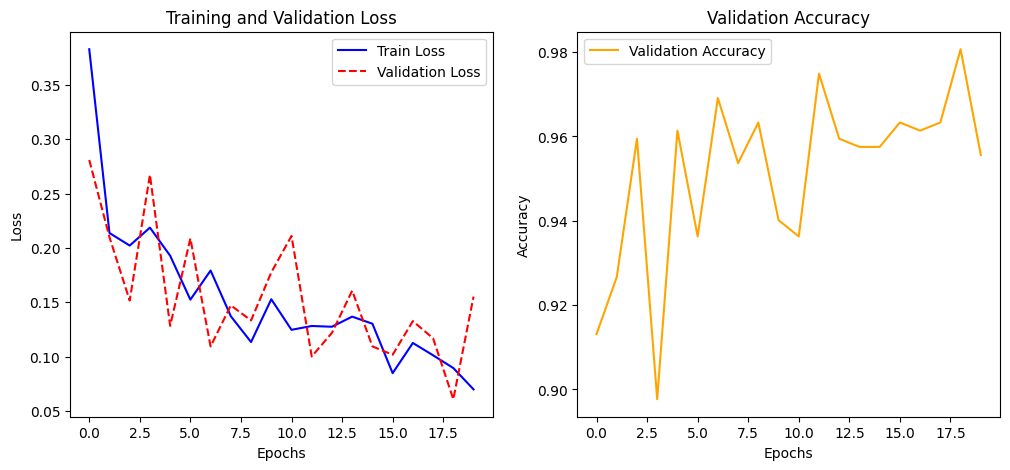

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(valid_losses, label="Validation Loss", color='red', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

In [18]:
torch.save(model.state_dict(), "real_fake_model.pth")
print("Model saved successfully.")

Model saved successfully.
